In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from datetime import datetime 
from pandas import Series 
            
%matplotlib inline 
sns.set(color_codes=True)

plt.style.use('fivethirtyeight')

# Data Importing and Exploration

## Importing data for ASIANPAINT company stock statistics

In [ ]:
url = 'https://drive.google.com/file/d/1nM8Lc7El4dr9eq-iMkhiw1z3ZnCQOejv/view?usp=sharing'
# path to data
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

In [ ]:
df = pd.read_csv(path)
df

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,ASIANPAINT,EQ,361.20,370.0,390.00,370.00,385.0,381.65,380.54,3318,1.262617e+11,NaN,NaN,NaN
1,2000-01-04,ASIANPAINT,EQ,381.65,380.0,392.00,375.00,390.0,385.55,383.50,4818,1.847699e+11,NaN,NaN,NaN
2,2000-01-05,ASIANPAINT,EQ,385.55,371.5,390.00,371.50,383.0,383.00,379.81,2628,9.981384e+10,NaN,NaN,NaN
3,2000-01-06,ASIANPAINT,EQ,383.00,384.9,384.90,374.50,375.1,377.50,379.88,3354,1.274114e+11,NaN,NaN,NaN
4,2000-01-07,ASIANPAINT,EQ,377.50,376.0,390.00,370.00,389.0,385.70,383.38,9589,3.676275e+11,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5301,2021-04-26,ASIANPAINT,EQ,2517.95,2530.0,2575.00,2530.00,2558.0,2557.90,2557.47,1103980,2.823400e+14,58557.0,335232.0,0.3037
5302,2021-04-27,ASIANPAINT,EQ,2557.90,2545.0,2579.90,2534.00,2571.0,2574.35,2560.55,866331,2.218288e+14,66988.0,281178.0,0.3246
5303,2021-04-28,ASIANPAINT,EQ,2574.35,2588.0,2620.25,2575.00,2612.0,2614.55,2605.91,1065561,2.776752e+14,52622.0,449241.0,0.4216
5304,2021-04-29,ASIANPAINT,EQ,2614.55,2630.0,2642.00,2570.00,2613.0,2613.45,2607.33,1295346,3.377394e+14,64039.0,447979.0,0.3458


## Performing Exploratory Analysis

In [ ]:
df.describe()

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
count,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5.306000e+03,5.306000e+03,2456.000000,4.797000e+03,4797.000000
mean,1247.000952,1247.683952,1264.625349,1230.900697,1247.317132,1247.410903,1247.799926,5.096721e+05,6.942919e+13,41346.011401,2.751281e+05,0.625572
std,1074.399506,1074.025577,1087.238871,1062.629409,1074.432667,1074.476439,1075.057438,8.535993e+05,1.443973e+14,36435.449733,4.157465e+05,0.187597
min,210.750000,210.000000,215.750000,204.000000,210.600000,210.750000,212.220000,2.500000e+01,1.278415e+09,70.000000,2.500000e+01,0.076800
25%,415.737500,415.000000,424.950000,410.000000,416.000000,416.262500,415.692500,1.370750e+04,7.538133e+11,16264.750000,1.262200e+04,0.486200
50%,889.375000,890.000000,903.975000,878.075000,890.000000,889.475000,888.350000,5.713600e+04,1.109437e+13,32402.500000,5.273800e+04,0.616100
75%,1599.037500,1599.800000,1629.675000,1573.037500,1602.500000,1600.762500,1600.982500,8.077905e+05,7.761479e+13,54727.500000,4.383750e+05,0.765500
max,5213.100000,5221.100000,5247.750000,5150.050000,5221.100000,5213.100000,5175.790000,1.154594e+07,2.216650e+15,351347.000000,7.938427e+06,1.000000


Things to note
- There is a large range for most variables, considering this is only one stock ticker. This is due to the large time range.
- The mean of most of the price metrics is around 1250 and SD is around 1075, so the stock price must have stayed around this price for a while. 
- We need to look for missing values in these columns

In [ ]:
df.isnull().sum()

Date                     0
Symbol                   0
Series                   0
Prev Close               0
Open                     0
High                     0
Low                      0
Last                     0
Close                    0
VWAP                     0
Volume                   0
Turnover                 0
Trades                2850
Deliverable Volume     509
%Deliverble            509
dtype: int64

We can see alot of missing values for "Trades" column and some for the deliverable columns. Likely trades will be a significant predictor for our model so we will need to test if deleting the rows with no trade value will affect test error. Deliverables will likely have no affect on prediction accuracy.

We can create a dataframe with NAs and without NAs for seperate testing to deal with these values. However, it will be hard use common substitutes for NA values as the range of trades is extremely large. This means we will need another substitute. 


In [ ]:
df.dtypes

Date                   object
Symbol                 object
Series                 object
Prev Close            float64
Open                  float64
High                  float64
Low                   float64
Last                  float64
Close                 float64
VWAP                  float64
Volume                  int64
Turnover              float64
Trades                float64
Deliverable Volume    float64
%Deliverble           float64
dtype: object

We can see that our date column is an object type instead of a datetime. We will need to handle this in order to do time-series analysis. 
As of now, we are just working with the ASIANPAINT stock, so we may be able to drop this column. This is the same for the series column, since all of the stocks we will be looking at are EQ series. 



In [ ]:
df = df.drop(columns = "Series")
df = df.drop(columns = "Symbol")
df = df.drop(columns = "%Deliverble")
df

,Date,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume
0,2000-01-03,361.20,370.0,390.00,370.00,385.0,381.65,380.54,3318,1.262617e+11,NaN,NaN
1,2000-01-04,381.65,380.0,392.00,375.00,390.0,385.55,383.50,4818,1.847699e+11,NaN,NaN
2,2000-01-05,385.55,371.5,390.00,371.50,383.0,383.00,379.81,2628,9.981384e+10,NaN,NaN
3,2000-01-06,383.00,384.9,384.90,374.50,375.1,377.50,379.88,3354,1.274114e+11,NaN,NaN
4,2000-01-07,377.50,376.0,390.00,370.00,389.0,385.70,383.38,9589,3.676275e+11,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5301,2021-04-26,2517.95,2530.0,2575.00,2530.00,2558.0,2557.90,2557.47,1103980,2.823400e+14,58557.0,335232.0
5302,2021-04-27,2557.90,2545.0,2579.90,2534.00,2571.0,2574.35,2560.55,866331,2.218288e+14,66988.0,281178.0
5303,2021-04-28,2574.35,2588.0,2620.25,2575.00,2612.0,2614.55,2605.91,1065561,2.776752e+14,52622.0,449241.0
5304,2021-04-29,2614.55,2630.0,2642.00,2570.00,2613.0,2613.45,2607.33,1295346,3.377394e+14,64039.0,447979.0


In [ ]:
df.Date = pd.to_datetime(df.Date)
saturdays = df[df.Date.dt.dayofweek == 5]  # 20 saturday values
sundays = df[df.Date.dt.dayofweek == 6]  # 4 sunday values

# Deleting weekend values from df
weekends = pd.concat([saturdays, sundays])
df = pd.concat([df, weekends]).drop_duplicates(keep=False)
df

,Date,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume
0,2000-01-03,361.20,370.0,390.00,370.00,385.0,381.65,380.54,3318,1.262617e+11,NaN,NaN
1,2000-01-04,381.65,380.0,392.00,375.00,390.0,385.55,383.50,4818,1.847699e+11,NaN,NaN
2,2000-01-05,385.55,371.5,390.00,371.50,383.0,383.00,379.81,2628,9.981384e+10,NaN,NaN
3,2000-01-06,383.00,384.9,384.90,374.50,375.1,377.50,379.88,3354,1.274114e+11,NaN,NaN
4,2000-01-07,377.50,376.0,390.00,370.00,389.0,385.70,383.38,9589,3.676275e+11,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5301,2021-04-26,2517.95,2530.0,2575.00,2530.00,2558.0,2557.90,2557.47,1103980,2.823400e+14,58557.0,335232.0
5302,2021-04-27,2557.90,2545.0,2579.90,2534.00,2571.0,2574.35,2560.55,866331,2.218288e+14,66988.0,281178.0
5303,2021-04-28,2574.35,2588.0,2620.25,2575.00,2612.0,2614.55,2605.91,1065561,2.776752e+14,52622.0,449241.0
5304,2021-04-29,2614.55,2630.0,2642.00,2570.00,2613.0,2613.45,2607.33,1295346,3.377394e+14,64039.0,447979.0


Text(0, 0.5, 'VWAP')

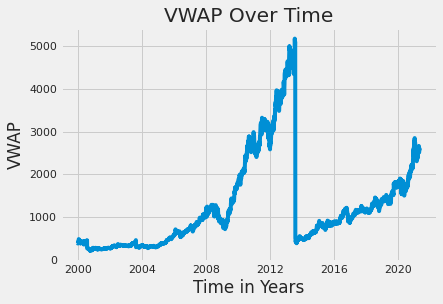

In [ ]:
df_vwap = pd.DataFrame()

df_vwap['year'] = df.Date.dt.year
df_vwap['date'] = df.Date
df_vwap['VWAP'] = df.VWAP
df_vwap['day of week'] = df.Date.dt.dayofweek

df_vwap.set_index('date', inplace = True)

plt.plot(df_vwap['VWAP'])
plt.title("VWAP Over Time")
plt.xlabel("Time in Years")
plt.ylabel("VWAP")

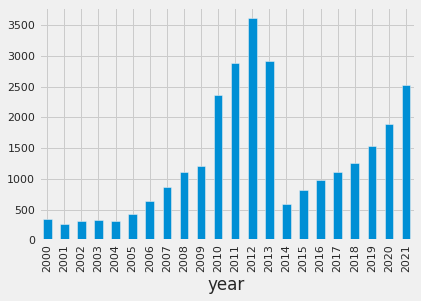

In [ ]:
df_vwap.groupby('year')['VWAP'].mean().plot.bar()

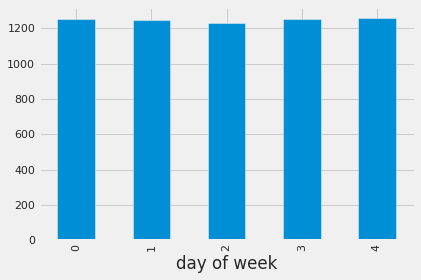

In [ ]:
df_vwap.groupby('day of week')['VWAP'].mean().plot.bar()

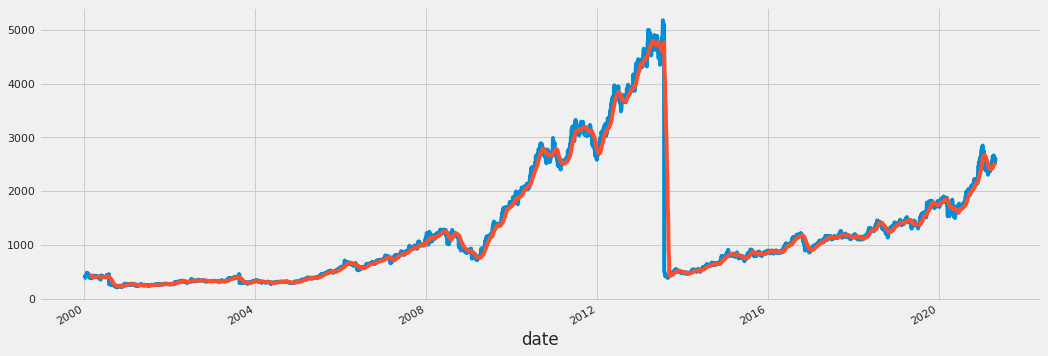

In [ ]:
# Showing rolling 30 day average
df_vwap['VWAP'].plot()
df_vwap.rolling(window=30).mean()['VWAP'].plot(figsize=(16, 6))

In [ ]:
# % of total Trades that are null
print(sum(df.Trades.isna()) / len(df.Trades))  # roughly 50% of Trades are null

# % of Deliverable Volume that is null 
print(sum(df['Deliverable Volume'].isna()) / len(df['Deliverable Volume']))

0.5372964786065885
0.09617569102612647


In [ ]:
# Replacing NA values with mean
df['Deliverable Volume'].fillna((df['Deliverable Volume'].mean()), inplace=True)
df['Deliverable Volume'] = round(df['Deliverable Volume'], 2)

# Dropping Trades column as there is no sufficient way to replace NAs and we have volume and VWAP to use instead
df = df.drop(columns = "Trades")
df.set_index('Date', inplace = True)

df.describe()

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Deliverable Volume
count,5282.000000,5282.000000,5282.000000,5282.000000,5282.00000,5282.000000,5282.000000,5.282000e+03,5.282000e+03,5.282000e+03
mean,1246.175123,1246.836473,1263.808396,1230.037988,1246.47199,1246.570901,1246.957620,5.115442e+05,6.968686e+13,2.762906e+05
std,1073.417670,1073.021952,1086.242492,1061.604200,1073.38506,1073.451108,1074.041105,8.549548e+05,1.446606e+14,3.958507e+05
min,210.750000,210.000000,215.750000,204.000000,210.60000,210.750000,212.220000,2.500000e+01,1.278415e+09,2.500000e+01
25%,415.737500,415.000000,424.950000,410.000000,416.00000,416.262500,415.692500,1.379975e+04,7.578066e+11,1.490825e+04
50%,889.475000,891.000000,904.000000,878.325000,890.00000,889.700000,889.650000,5.739350e+04,1.130866e+13,8.838000e+04
75%,1596.937500,1598.700000,1622.612500,1569.787500,1595.75000,1597.525000,1597.707500,8.091125e+05,7.794690e+13,4.017038e+05
max,5213.100000,5221.100000,5247.750000,5150.050000,5221.10000,5213.100000,5175.790000,1.154594e+07,2.216650e+15,7.938427e+06


In [ ]:
# add a prediction column for close prices of next day
# Shift Close up one row, append current (row i+1) value to pred_c column
df['pred_c'] = df.Close.shift(-1)

# drops last row, which is missing pred_c data
df = df.dropna()
df

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Deliverable Volume,pred_c
Date,,,,,,,,,,,
2000-01-03,361.20,370.0,390.00,370.0,385.0,381.65,380.54,3318,1.262617e+11,276290.56,385.55
2000-01-04,381.65,380.0,392.00,375.0,390.0,385.55,383.50,4818,1.847699e+11,276290.56,383.00
2000-01-05,385.55,371.5,390.00,371.5,383.0,383.00,379.81,2628,9.981384e+10,276290.56,377.50
2000-01-06,383.00,384.9,384.90,374.5,375.1,377.50,379.88,3354,1.274114e+11,276290.56,385.70
2000-01-07,377.50,376.0,390.00,370.0,389.0,385.70,383.38,9589,3.676275e+11,276290.56,415.00
...,...,...,...,...,...,...,...,...,...,...,...
2021-04-23,2511.25,2527.1,2565.00,2496.2,2520.0,2517.95,2523.48,1614593,4.074400e+14,387340.00,2557.90
2021-04-26,2517.95,2530.0,2575.00,2530.0,2558.0,2557.90,2557.47,1103980,2.823400e+14,335232.00,2574.35
2021-04-27,2557.90,2545.0,2579.90,2534.0,2571.0,2574.35,2560.55,866331,2.218288e+14,281178.00,2614.55


In [ ]:
values = df.values
values = values.astype('float32')
values

array([[3.6120001e+02, 3.7000000e+02, 3.9000000e+02, ..., 1.2626172e+11,
        2.7629056e+05, 3.8554999e+02],
       [3.8164999e+02, 3.8000000e+02, 3.9200000e+02, ..., 1.8476987e+11,
        2.7629056e+05, 3.8300000e+02],
       [3.8554999e+02, 3.7150000e+02, 3.9000000e+02, ..., 9.9813843e+10,
        2.7629056e+05, 3.7750000e+02],
       ...,
       [2.5578999e+03, 2.5450000e+03, 2.5798999e+03, ..., 2.2182875e+14,
        2.8117800e+05, 2.6145500e+03],
       [2.5743501e+03, 2.5880000e+03, 2.6202500e+03, ..., 2.7767519e+14,
        4.4924100e+05, 2.6134500e+03],
       [2.6145500e+03, 2.6300000e+03, 2.6420000e+03, ..., 3.3773942e+14,
        4.4797900e+05, 2.5363999e+03]], dtype=float32)

In [ ]:
scaler = MinMaxScaler(feature_range= (0,1))

scaled = scaler.fit_transform(values)
scaled = pd.DataFrame(scaled)
scaled.columns = df.columns
scaled['Date'] = df.index
scaled.set_index('Date', inplace = True)
scaled

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Deliverable Volume,pred_c
Date,,,,,,,,,,,
2000-01-03,0.030076,0.031929,0.034628,0.033562,0.034807,0.034164,0.033911,0.000285,0.000056,0.034801,0.034944
2000-01-04,0.034164,0.033925,0.035026,0.034573,0.035805,0.034944,0.034507,0.000415,0.000083,0.034801,0.034434
2000-01-05,0.034944,0.032228,0.034628,0.033865,0.034408,0.034434,0.033764,0.000225,0.000044,0.034801,0.033334
2000-01-06,0.034434,0.034903,0.033615,0.034472,0.032831,0.033334,0.033778,0.000288,0.000057,0.034801,0.034974
2000-01-07,0.033334,0.033126,0.034628,0.033562,0.035605,0.034974,0.034483,0.000828,0.000165,0.034801,0.040831
...,...,...,...,...,...,...,...,...,...,...,...
2021-04-23,0.459884,0.462394,0.466862,0.463441,0.460912,0.461223,0.465645,0.139839,0.183808,0.048790,0.469209
2021-04-26,0.461223,0.462972,0.468849,0.470274,0.468496,0.469209,0.472493,0.095614,0.127372,0.042226,0.472498
2021-04-27,0.469209,0.465966,0.469823,0.471083,0.471091,0.472498,0.473113,0.075031,0.100073,0.035417,0.480534


In [ ]:
# dont use testing
def dhist (df, window = 60, pred = 1):
    d = df.copy()
    d["id"] = range(1, len(d)+1)
    d = d.iloc[:-window, :]
    d.set_index('id', inplace = True)
    p_value = df.copy()
    p_value = p_value.iloc[window:, pred]
    p_value.columns = ["pred_c"]
    p_value = pd.DataFrame(p_value)
    
    p_value["id"] = range(1, len(p_value)+1)
    p_value.set_index('id', inplace = True)
    f_df = pd.concat([d, p_value], axis = 1)
    
    return f_df

In [ ]:
# planning out shape of data

# shape of input:
# (number_of_records x length_of_sequence x types_of_sequences)
# (5305 * 1 x 10)

# shape of output:
# (number_of_records x types_of_sequences)
# (5305 * 1)

scaled

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Deliverable Volume,pred_c
Date,,,,,,,,,,,
2000-01-03,0.030076,0.031929,0.034628,0.033562,0.034807,0.034164,0.033911,0.000285,0.000056,0.034801,0.034944
2000-01-04,0.034164,0.033925,0.035026,0.034573,0.035805,0.034944,0.034507,0.000415,0.000083,0.034801,0.034434
2000-01-05,0.034944,0.032228,0.034628,0.033865,0.034408,0.034434,0.033764,0.000225,0.000044,0.034801,0.033334
2000-01-06,0.034434,0.034903,0.033615,0.034472,0.032831,0.033334,0.033778,0.000288,0.000057,0.034801,0.034974
2000-01-07,0.033334,0.033126,0.034628,0.033562,0.035605,0.034974,0.034483,0.000828,0.000165,0.034801,0.040831
...,...,...,...,...,...,...,...,...,...,...,...
2021-04-23,0.459884,0.462394,0.466862,0.463441,0.460912,0.461223,0.465645,0.139839,0.183808,0.048790,0.469209
2021-04-26,0.461223,0.462972,0.468849,0.470274,0.468496,0.469209,0.472493,0.095614,0.127372,0.042226,0.472498
2021-04-27,0.469209,0.465966,0.469823,0.471083,0.471091,0.472498,0.473113,0.075031,0.100073,0.035417,0.480534


In [ ]:
# Organizing training and testing data
X = scaled.drop(columns=['pred_c']).to_numpy()
X = np.expand_dims(X, axis=2)

Y = scaled.pred_c.to_numpy() 
Y = np.expand_dims(Y, axis=1)

X.shape, Y.shape

# Split 80/20
cutoff = int(X.shape[0] * 0.8)
X_train, X_test = X[:cutoff], X[cutoff:]
Y_train, Y_test = Y[:cutoff], Y[cutoff:]
print(X.shape, Y.shape)

(5281, 10, 1) (5281, 1)


In [ ]:
epochs = 5       
learning_rate = 0.0001    
seq_len = 10                   

hidden_dim = 100         
output_dim = 1

min_value = -10
max_value = 10

In [ ]:
U = np.random.uniform(0, 1, (hidden_dim, seq_len))
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim))
V = np.random.uniform(0, 1, (output_dim, hidden_dim))

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [ ]:
def relu(x):
    return max(0.0, np.average(x))

In [ ]:
def forward_pass(x, seq_len, prev_act, U, V, W, verbose=False):
    layers = []
    i = 0
    while i < seq_len:
        input = np.zeros(x.shape)    # we then do a forward pass for every timestep in the sequence
        input[i] = x[i]              # for this, we define a single input for that timestep
        new_u = np.dot(U, input)
        new_w = np.dot(W, prev_act)
        add = new_w + new_u
        act = sigmoid(add)
        new_v = np.dot(V, act)
        prev_act = act 
        layers.append({'act': act, 'prev_act': prev_act})
        i += 1
    weights = {'new_u': new_u, 'new_v': new_v, 'new_w': new_w}
    if verbose:
        return (layers, add, weights)
    else:
        return weights 

In [ ]:
def get_loss(X, Y, seq_len, U, V, W):
    loss = 0.0
    for x, y in zip(X, Y):
        prev_act = np.zeros((hidden_dim, 1))   # here, prev-s is the value of the previous activation of hidden layer; which is initialized as all zeroes
        weights = forward_pass(x, seq_len, prev_act, U, V, W)
        loss += (y - weights['new_v'])**2 / 2
    
    return loss / float(y.shape[0])

In [ ]:
def train_model(X, Y, seq_len, U, V, W):
    for x, y in zip(X, Y):
        d_U = d_U_t = np.zeros(U.shape)
        d_V = d_V_t = np.zeros(V.shape)
        d_W = d_W_t = np.zeros(W.shape)
        
        # forward pass
        prev_act = np.zeros((hidden_dim, 1))
        layers, add, weights = forward_pass(x, seq_len, prev_act, U, V, W, verbose=True)
        d_new_v = (weights['new_v'] - y)
        
        # backward pass
        i = 0
        while i < seq_len:
            d_act = d_base = np.dot(np.transpose(V), d_new_v)
            d_add = add * (1 - add) * d_act

            d_new_w = d_add * np.ones_like(weights['new_w'])
            d_prev_act = np.dot(np.transpose(W), d_new_w)
            
            d_V_t = np.dot(d_new_v, np.transpose(layers[i]['act']))

            for _ in range(i-1, -1, -1):
                d_act = d_base + d_prev_act
                d_add = add * (1 - add) * d_act

                d_new_w = np.ones_like(weights['new_w']) * d_add  
                d_new_u = np.ones_like(weights['new_u']) * d_add 

                d_prev_act = np.dot(np.transpose(W), d_new_w)

                input = np.zeros(x.shape)
                input[i] = x[i]
                d_x = np.dot(np.transpose(U), d_new_u)
                
                d_U_t += np.dot(U, input) 
                d_W_t += np.dot(W, layers[i]['prev_act'])

            # Update weights
            d_V += d_V_t
            d_U += d_U_t
            d_W += d_W_t

            for d in [d_U, d_V, d_W]:
                if d.max() > max_value:
                    d[d > max_value] = max_value
                if d.min() < min_value:
                    d[d < min_value] = min_value

            i += 1

        # update
        U -= learning_rate * d_U
        V -= learning_rate * d_V
        W -= learning_rate * d_W

    return (U, V, W)


In [ ]:
for epoch in range(epochs):
    global U, V, W
    # check loss on train
    loss = get_loss(X_train, Y_train, seq_len, U, V, W)
    val_loss = get_loss(X_test, Y_test, seq_len, U, V, W)

    print('Epoch: ', epoch + 1, '| Loss:', loss[0][0], '| Val Loss:', val_loss[0][0])

    U, V, W = train_model(X_train, Y_train, seq_len, U, V, W)

Epoch:  1 | Loss: 5507596.706504483 | Val Loss: 1374282.6669355407
Epoch:  2 | Loss: 96.0805523108137 | Val Loss: 10.01997791034753
Epoch:  3 | Loss: 101.91305925142653 | Val Loss: 17.5656496530835
Epoch:  4 | Loss: 99.37555395696516 | Val Loss: 15.693565820142938
Epoch:  5 | Loss: 95.84917636837562 | Val Loss: 9.953232125990624


In [ ]:
preds = []
for x, y in zip(X_train, Y_train):
    prev_act = np.zeros((hidden_dim, 1))
    i = 0
    while i < seq_len:
        new_u = np.dot(U, x)
        new_w = np.dot(W, prev_act)
        add = new_w + new_u
        act = sigmoid(add)
        new_v = np.dot(V, act)
        prev_act = act
        i += 1
    preds.append(new_v)
preds = np.array(preds)

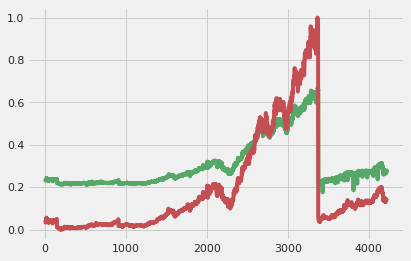

In [ ]:
plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y_train[:, 0], 'r')
plt.show()